In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import langevin
import langevin_cached_model as lcm
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar
import theano.tensor as tt


SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic1(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/2/A**2
    Btmp = (N-1)*(1+B**2)/(1-B**2)**2
    tmp = (2+6*B**2)*(data1sq+dataNsq) + (4+12*B**2)*datasq - (12*B+4*B**3)*datacorr
    P2B = Btmp - tmp/A/2/(1-B**2)**3
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult1(data,deltat):
    A, dA, B ,dB = OUanalytic1(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
# function to calculate A and B from the dataset
def OUanalytic2(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult2(data,deltat):
    A, dA, B ,dB = OUanalytic2(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [4]:
class Ornstein_Uhlenbeck(pm.Continuous):
    """
    Ornstein-Uhlenbeck Process
    Parameters
    ----------
    B : tensor
        B > 0, B = exp(-(D/A)*delta_t)
    A : tensor
        A > 0, amplitude of fluctuation <x**2>=A
    delta_t: scalar
        delta_t > 0, time step
    """

    def __init__(self, A=None, B=None,
                 *args, **kwargs):
        super(Ornstein_Uhlenbeck, self).__init__(*args, **kwargs)
        self.A = A
        self.B = B
        self.mean = 0.

    def logp(self, x):
        A = self.A
        B = self.B

        x_im1 = x[:-1]
        x_i = x[1:]

        ou_like = pm.Normal.dist(mu=x_im1*B, tau=1.0/A/(1-B**2)).logp(x_i)
        return pm.Normal.dist(mu=0.0,tau=1.0/A).logp(x[0]) + tt.sum(ou_like)


In [5]:
A,D = 1.0,1.0
delta_t_list=np.linspace(0.01,4,50)
#M=1000 # number of data sets
N=100000 # length of data set
#print(np.exp(-delta_t*D/A))

In [6]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

result_Bayes_array = None
for delta_t in delta_t_list:
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult1(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

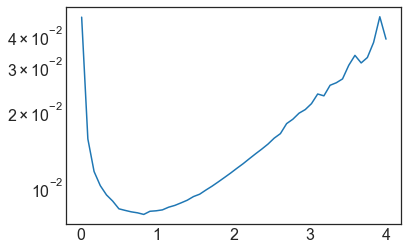

In [7]:
plt.semilogy(delta_t_list,result_Bayes_array.T[3])

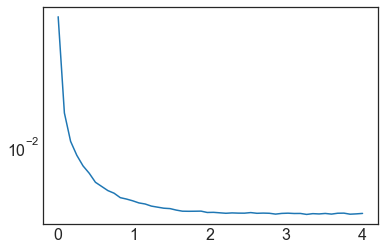

In [8]:
plt.semilogy(delta_t_list,result_Bayes_array.T[1])

In [9]:
AA,DD = 1.0,1.0
tau_real = AA/DD
delta_t_list=np.linspace(0.01,4,50)
#M=1000 # number of data sets
N=100000 # length of data set
#print(np.exp(-delta_t*D/A))
pick_delta = 7
print(delta_t_list[pick_delta])
data = langevin.time_series(A=AA, D=DD, delta_t=delta_t_list[pick_delta], N=N)

0.5800000000000001


In [10]:
d_bound=20
a_bound=20
delta_t=delta_t_list[pick_delta]
# compile model for reuse
with pm.Model() as model:
    D = pm.Uniform('D', lower=0, upper=d_bound)
    A = pm.Uniform('A', lower=0, upper=a_bound)

    B = pm.Deterministic('B', pm.math.exp(-delta_t * D / A))

    path = Ornstein_Uhlenbeck('path',A=A, B=B, observed=data)
    
    trace = pm.sample(20000,tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:39<00:00, 1208.89draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2a070c50>,
      dtype=object)

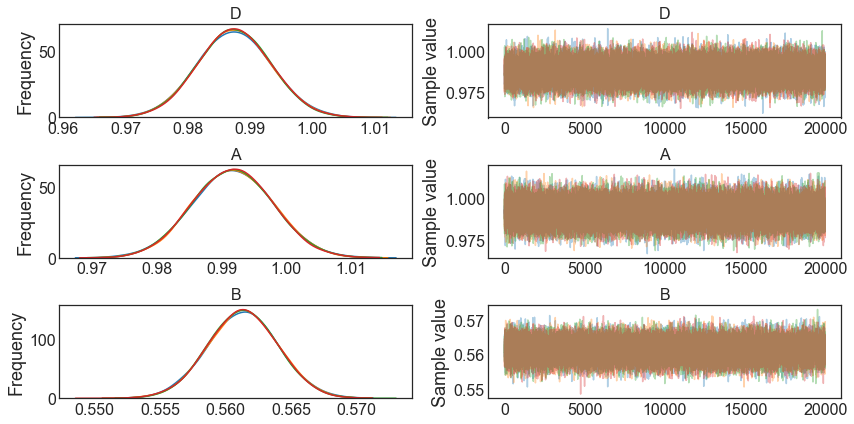

In [11]:
pm.traceplot(trace)

In [12]:
result_array = None
for delta_t in delta_t_list:
    print(delta_t)
    data = langevin.time_series(A=AA, D=DD, delta_t=delta_t, N=N)
    with pm.Model() as model:
        D = pm.Uniform('D', lower=0, upper=d_bound)
        A = pm.Uniform('A', lower=0, upper=a_bound)

        B = pm.Deterministic('B', pm.math.exp(-delta_t * D / A))

        path = Ornstein_Uhlenbeck('path',A=A, B=B, observed=data)
    
        trace = pm.sample(20000,tune=10000)
        
    a_mean = trace['A'].mean()
    d_mean = trace['D'].mean()
    a_std = trace['A'].std()
    d_std = trace['D'].std()
    results = [a_mean,a_std,d_mean,d_std]
    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))

0.01


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:59<00:00, 1004.11draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.6707121158890552, but should be close to 0.8. Try to increase the number of tuning steps.


0.09142857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:40<00:00, 1188.48draws/s]


0.17285714285714288


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:38<00:00, 1212.38draws/s]


0.2542857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:38<00:00, 1219.46draws/s]


0.33571428571428574


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:40<00:00, 429.15draws/s] 


0.41714285714285715


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:42<00:00, 1166.13draws/s]


0.4985714285714286


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:37<00:00, 1228.13draws/s]


0.5800000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:37<00:00, 1227.40draws/s]


0.6614285714285715


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:43<00:00, 1160.79draws/s]


0.7428571428571429


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:44<00:00, 1152.83draws/s]


0.8242857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:43<00:00, 1160.17draws/s]


0.9057142857142858


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:38<00:00, 1213.21draws/s]


0.9871428571428572


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:49<00:00, 1091.07draws/s]


1.0685714285714287


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:49<00:00, 1100.07draws/s]


1.1500000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:53<00:00, 1057.39draws/s]


1.2314285714285715


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:48<00:00, 1109.77draws/s]


1.312857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:52<00:00, 1070.93draws/s]


1.3942857142857144


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:52<00:00, 1061.97draws/s]


1.4757142857142858


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:07<00:00, 938.59draws/s] 


1.5571428571428572


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:02<00:00, 976.93draws/s] 


1.6385714285714286


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:24<00:00, 831.93draws/s] 


1.7200000000000002


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:23<00:00, 837.44draws/s] 


1.8014285714285716


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:24<00:00, 828.31draws/s] 


1.882857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:24<00:00, 828.63draws/s] 
The acceptance probability does not match the target. It is 0.7211230460996797, but should be close to 0.8. Try to increase the number of tuning steps.


1.9642857142857144


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:10<00:00, 918.02draws/s] 


2.045714285714286


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:25<00:00, 822.19draws/s] 
The acceptance probability does not match the target. It is 0.7018979069548527, but should be close to 0.8. Try to increase the number of tuning steps.


2.1271428571428572


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:13<00:00, 896.42draws/s] 


2.2085714285714286


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:49<00:00, 1099.60draws/s]


2.29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:12<00:00, 907.59draws/s] 


2.3714285714285714


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:58<00:00, 1014.83draws/s]


2.452857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:46<00:00, 1121.68draws/s]


2.5342857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:56<00:00, 1026.88draws/s]


2.6157142857142857


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:58<00:00, 1015.53draws/s]


2.697142857142857


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:00<00:00, 997.23draws/s] 


2.7785714285714285


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:09<00:00, 929.76draws/s] 


2.86


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:09<00:00, 368.59draws/s] 


2.9414285714285713


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:04<00:00, 962.99draws/s] 


3.0228571428571427


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:03<00:00, 975.40draws/s] 


3.104285714285714


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [01:47<00:00, 1114.47draws/s]


3.1857142857142855


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:06<00:00, 947.32draws/s] 


3.267142857142857


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:13<00:00, 898.83draws/s] 


3.3485714285714288


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:16<00:00, 879.91draws/s] 
The acceptance probability does not match the target. It is 0.6615696348006885, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7139275217757943, but should be close to 0.8. Try to increase the number of tuning steps.


3.43


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:11<00:00, 910.37draws/s] 


3.5114285714285716


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:19<00:00, 862.04draws/s]


3.592857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:46<00:00, 719.54draws/s]
The acceptance probability does not match the target. It is 0.6303915595261954, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8817741970464621, but should be close to 0.8. Try to increase the number of tuning steps.


3.6742857142857144


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:44<00:00, 730.14draws/s]


3.755714285714286


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:54<00:00, 688.02draws/s]


3.837142857142857


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:50<00:00, 705.65draws/s]


3.9185714285714286


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:51<00:00, 700.28draws/s]


4.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 120000/120000 [03:00<00:00, 664.41draws/s]
The number of effective samples is smaller than 10% for some parameters.


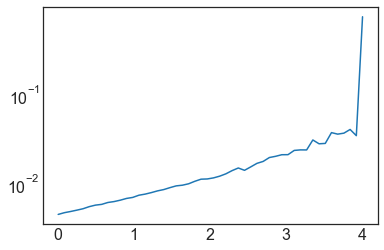

In [13]:
plt.semilogy(delta_t_list,result_array.T[3])

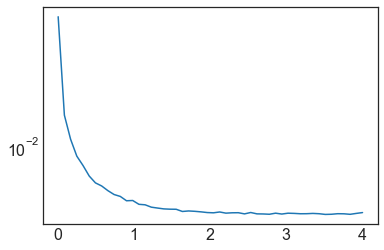

In [14]:
plt.semilogy(delta_t_list,result_array.T[1])

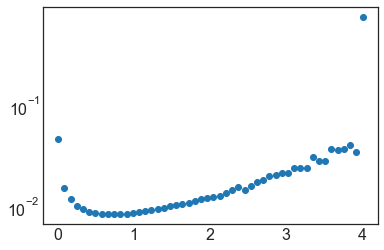

In [15]:
dtau = np.sqrt(result_array.T[1]**2+result_array.T[3]**2)
plt.semilogy(delta_t_list,dtau,"o")

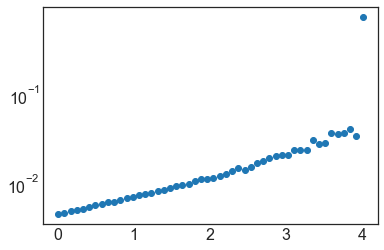

In [16]:
plt.semilogy(delta_t_list,result_array.T[3],"o",label=r"$dD/D$")

In [20]:
# function to calculate A and B from the dataset
def OUlargeN(N,A,B):
    data1sq = A
    dataNsq = A
    datasq = (N-2)*A
    datacorr = (N-1)*A*B
    P2A = -N/2/A**2
    Btmp = (N-1)*(1+B**2)/(1-B**2)**2
    tmp = (2+6*B**2)*(data1sq+dataNsq) + (4+12*B**2)*datasq - (12*B+4*B**3)*datacorr
    P2B = Btmp - tmp/A/2/(1-B**2)**3
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return dA,dB

def OUlargeN2(deltat,N,A,tau):
    dA,dB = OUlargeN(N,A,np.exp(-deltat/tau))
    dtau = np.exp(deltat/tau)*tau/deltat*dB
    return dA,dtau

def OUlargeNdtau(deltat,N,A,tau):
    dA,dB = OUlargeN(N,A,np.exp(-deltat/tau))
    dtau = np.exp(deltat/tau)*tau/deltat*dB
    return dtau


In [21]:
dAt,dtaut = OUlargeN2(delta_t_list,100000,1,1)

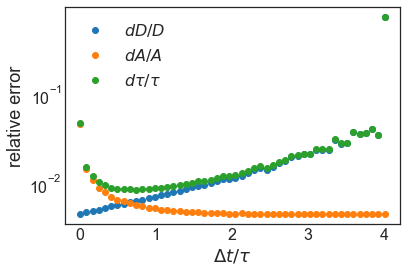

In [17]:
plt.semilogy(delta_t_list,result_array.T[3],"o",label=r"$dD/D$")
plt.semilogy(delta_t_list,result_array.T[1],"o",label=r'$dA/A$')
plt.semilogy(delta_t_list,dtau,"o",label=r'$d\tau/\tau$')
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
plt.legend()

In [32]:
result_array.T[3][:-1]

array([0.00448436, 0.00469024, 0.00483756, 0.0050082 , 0.00519471,
       0.00548525, 0.00570548, 0.00581807, 0.00610982, 0.00625748,
       0.00648739, 0.00678642, 0.00696807, 0.00737972, 0.00759159,
       0.00789547, 0.0082585 , 0.00854288, 0.00898338, 0.0094004 ,
       0.00956691, 0.00992503, 0.01058945, 0.01118118, 0.01124841,
       0.01156248, 0.01209093, 0.01285228, 0.01396464, 0.01494869,
       0.01407299, 0.0153801 , 0.01685775, 0.0177234 , 0.01960731,
       0.02023764, 0.02108697, 0.02112391, 0.02357771, 0.02390514,
       0.02387387, 0.03091935, 0.02800515, 0.02827125, 0.03741653,
       0.03596699, 0.03689829, 0.04060072, 0.0345806 ])

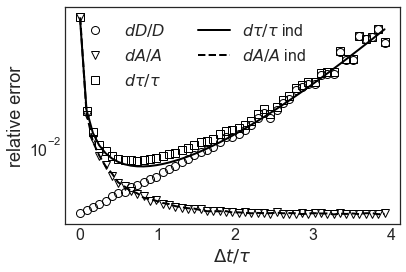

In [38]:
plt.semilogy(delta_t_list[:-1],result_array.T[3][:-1]/DD,"ko",markersize=8,fillstyle="none",markeredgewidth=1,markeredgecolor="k",label=r"$dD/D$")
plt.semilogy(delta_t_list[:-1],result_array.T[1][:-1]/AA,"kv",markersize=8,fillstyle="none",markeredgewidth=1,markeredgecolor="k",label=r'$dA/A$')
plt.semilogy(delta_t_list[:-1],dtau[:-1]/tau_real,"ks",markersize=8,fillstyle="none",markeredgewidth=1,markeredgecolor="k",label=r'$d\tau/\tau$')
plt.semilogy(delta_t_list[:-1],dtaut[:-1],"k-",label=r"$d\tau/\tau$ ind",linewidth=2)
plt.semilogy(delta_t_list[:-1],result_Bayes_array.T[1][:-1]/AA,"k--",label=r"$dA/A$ ind",linewidth=2)
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
plt.legend(ncol=2)
plt.savefig("optimaldt_1_1.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [19]:
data_label = "1_1"
np.save("dtnorm_"+data_label,delta_t_list/tau_real)
np.save("dD_D_"+data_label,result_array.T[3]/DD)
np.save("dA_A_"+data_label,result_array.T[1]/AA)
np.save("dtau_tau_"+data_label,dtau/tau_real)
np.save("dtau_tau_ind_"+data_label,result_Bayes_array.T[3]/tau_real)
np.save("dA_A_ind_"+data_label,result_Bayes_array.T[1]/AA)
